In [1]:
import pandas as pd
import geopandas as gpd
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# Goal of the notebook

In the previous analysis, we already have found, that the pareto fronts of buildings generally have two different scale of slopes, but we don't know what causes this split. In this notebook, we will try to implement a machine learning model called random forest to predict the slope of the pareto front.

## Data preparation
All inputs of CEA are loaded from dbf files into a pandas dataframe. Some of the columns contains irrelevant information, so we drop them. Then, pass the dataframe to further processing.

In [2]:
# first define a helper function that load dbf file automatically and return a pandas dataframe, with the index set to the building id in column called "Name"
# since pycharm for some reason doesn't work well with gdf, we create an empty df file, set the same index and concat the gdf to it
def get_gdf_from_dbf(dbf_path):
    gdf = gpd.read_file(dbf_path)
    gdf.drop(columns=["geometry"], inplace=True)
    df = pd.DataFrame()
    df = pd.concat([df, gdf], axis=1)
    df.set_index("Name", inplace=True)
    return df

In [3]:
# load the dbf files
scenario_path = r"C:\Users\wangy\OneDrive\ETHY2FW\IDP_Personal\CEA\2050 w3\inputs"
zone_df = get_gdf_from_dbf(scenario_path + r"\building-geometry\zone.dbf")
zone_gdf = gpd.read_file(scenario_path + r"\building-geometry\zone.dbf")
zone_gdf.set_index("Name", inplace=True)
# calculate the area of each zone, length of the geometry, and calculate the volume and surface area ratio
# volumn = area * height_ag, surface area = area + length * height_ag
zone_df['area'] = zone_gdf['geometry'].area
zone_df['length'] = zone_gdf['geometry'].length
zone_df['volume'] = zone_df['area'] * zone_df['height_ag']
zone_df['surface_area'] = zone_df['area'] + zone_df['length'] * zone_df['height_ag']
zone_df['surface_area_ratio'] = zone_df['surface_area'] / zone_df['volume']

In [4]:
# get all dbfs from the following subfolder
dbf_folder = scenario_path + r"\building-properties"
dbf_files = os.listdir(dbf_folder)
for file in dbf_files:
    if file.endswith(".dbf"):
        dbf_path = dbf_folder + "\\" + file
        df = get_gdf_from_dbf(dbf_path)
        # set the prefix of the column name to the name of the dbf file
        df.columns = [file[:-4] + "_" + col for col in df.columns]
        zone_df = pd.concat([zone_df, df], axis=1)
        
# drop the columns that are not relevant to the analysis
ls_irr_columns = ['h_boden', 'h_trauf', 'h_first', 'h_mean', 'egid', 'height_wit', 'height_bg2', 'floors_bg2', 
                  'floors_ag2', 'height_ag2', 'country', 'city', 'postcode', 'REFERENCE', 'house_no', 'street']
zone_df.drop(columns=ls_irr_columns, inplace=True)

In [7]:
# read pareto front csv files from subfolder 'result_pareto', calculate the slope of pareto front and add it to the zone_df
# the pareto csv contains columns of cost, emission, and technologies; rows are different epsilon cuts of the pareto front
# the name of the csv file is the building id
pareto_folder = './result_pareto_2'
pareto_files = os.listdir(pareto_folder)
for csv in pareto_files:
    if csv.endswith(".csv"):
        csv_path = pareto_folder + "/" + csv
        df_pareto = pd.read_csv(csv_path, index_col=0)
        # calculate the slope of the pareto front
        slope = -(df_pareto.loc[3, 'cost'] - df_pareto.loc[1, 'cost']) / (df_pareto.loc[3, 'emission'] - df_pareto.loc[1, 'emission'])
        # if the slope larger than 900, we categorize it as 1, otherwise 0
        if slope > 900:
            zone_df.loc[csv[:-11], 'slope_cat'] = 1
        else:
            zone_df.loc[csv[:-11], 'slope_cat'] = 0
        zone_df.loc[csv[:-11], 'slope'] = slope
            
# drop the rows that don't have slope value
zone_df.dropna(subset=['slope'], inplace=True)
# if slope_cat is 1, drop it
# zone_df.drop(zone_df[zone_df['slope_cat'] == 1].index, inplace=True)

C:\Users\wangy\AppData\Local\Temp\ipykernel_9768\4018087735.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  slope = -(df_pareto.loc[3, 'cost'] - df_pareto.loc[1, 'cost']) / (df_pareto.loc[3, 'emission'] - df_pareto.loc[1, 'emission'])
C:\Users\wangy\AppData\Local\Temp\ipykernel_9768\4018087735.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  slope = -(df_pareto.loc[3, 'cost'] - df_pareto.loc[1, 'cost']) / (df_pareto.loc[3, 'emission'] - df_pareto.loc[1, 'emission'])
C:\Users\wangy\AppData\Local\Temp\ipykernel_9768\4018087735.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  slope = -(df_pareto.loc[3, 'cost'] - df_pareto.loc[1, 'cost']) / (df_pareto.loc[3, 'emission'] - df_pareto.loc[1, 'emission'])
C:\Users\wangy\AppData\Local\Temp\ipykernel_9768\4018087735.py:11: RuntimeWarning: invalid value encountered in double_scalars
  slope = -(df_pareto.loc[3, 'cost'] - df_pareto.loc[1, 'cost']) / (df_pareto.loc[3, 'emission'] - df_

## Data preprocessing

Now, we have a dataframe with all the inputs and the slope of the pareto front. We need to preprocess the data before we can feed it to the machine learning model.

In [108]:
X = zone_df.drop(columns=['slope', 'slope_cat'])
y = zone_df['slope_cat']

# identify categorical and numerical columns
categorial_columns = X.select_dtypes(include=['object']).columns
numerical_columns = X.select_dtypes(include=['float', 'int']).columns

# create a pipeline for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(), categorial_columns)])

# create a pipeline for the whole model
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', RandomForestClassifier(random_state=42))])

# fit the model
pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['height_ag', 'height_bg', 'floors_ag', 'floors_bg', 'area', 'length',
       'volume', 'surface_area', 'surface_area_ratio', 'architecture_Hs_ag',
       'architecture_Hs_bg', 'architecture_Ns', 'architecture_Es',
       'architecture_void_deck', 'architecture_wwr_north',
       'architecture_wwr_...
       'architecture_type_roof', 'architecture_type_wall',
       'architecture_type_win', 'architecture_type_shade',
       'supply_systems_type_el', 'supply_systems_type_hs',
       'supply_systems_type_cs', 'supply_systems_type_dhw', 'typology_1ST_USE',
       'typology_2ND_USE', 'typology_3RD_USE', 'typology_REFERENCE',
       'typology_STANDARD'],
      dtype='object'))])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [109]:
# get the feature importance
feature_importance = pipeline.named_steps['classifier'].feature_importances_
one_hot_columns = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out()
feature_importance_df = pd.DataFrame({'feature': list(numerical_columns) + list(one_hot_columns), 'importance': feature_importance})
feature_importance_df.sort_values(by='importance', ascending=False, inplace=True)

In [110]:
# get the total importance of each category
total_importance_df = pd.DataFrame(columns=['category', 'total_importance'])
for category in categorial_columns:
    total_importance = feature_importance_df[feature_importance_df['feature'].str.startswith(category)]['importance'].sum()
    total_importance_df = pd.concat([total_importance_df, pd.DataFrame({'category': category, 'total_importance': total_importance}, index=[0])])
    
# also add the total importance of numerical columns
for numerical in numerical_columns:
    total_importance = feature_importance_df[feature_importance_df['feature'] == numerical]['importance'].sum() # no sum needed since there is only one value
    total_importance_df = pd.concat([total_importance_df, pd.DataFrame({'category': numerical, 'total_importance': total_importance}, index=[0])])

total_importance_df.sort_values(by='total_importance', ascending=False, inplace=True)

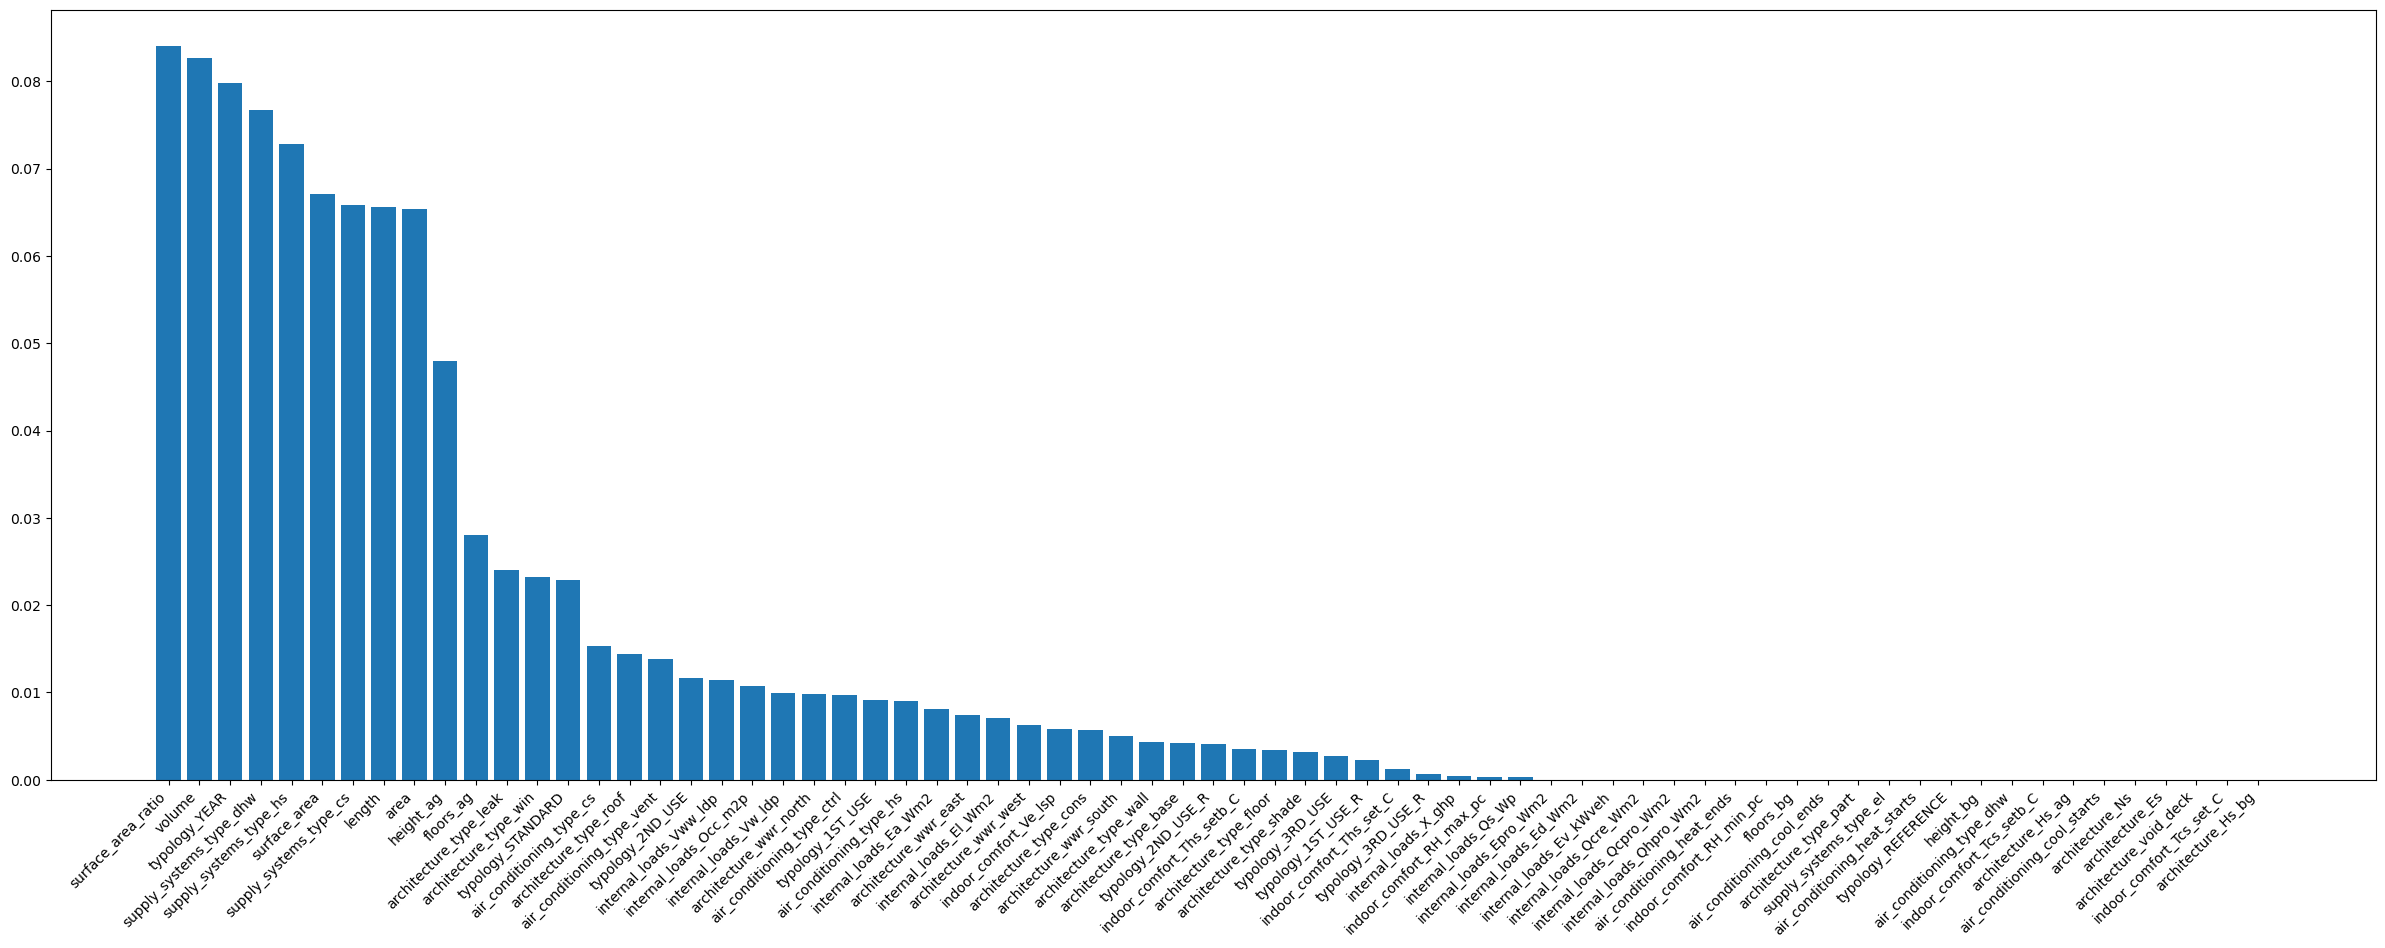

In [111]:
# plot the total importance of each category
plt.figure(figsize=(30, 10))
plt.bar(total_importance_df['category'], total_importance_df['total_importance'])
plt.xticks(rotation=45, ha='right')
plt.show()

In [112]:
# now that we have the real values of slope, we can do regression instead of classification
# we will use the same pipeline as before, but change the classifier to random forest regressor
pipeline_regression = Pipeline(steps=[('preprocessor', preprocessor),
                                      ('regressor', RandomForestRegressor(random_state=42))])

y2 = zone_df['slope']
pipeline_regression.fit(X, y2)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['height_ag', 'height_bg', 'floors_ag', 'floors_bg', 'area', 'length',
       'volume', 'surface_area', 'surface_area_ratio', 'architecture_Hs_ag',
       'architecture_Hs_bg', 'architecture_Ns', 'architecture_Es',
       'architecture_void_deck', 'architecture_wwr_north',
       'architecture_wwr_...
       'architecture_type_roof', 'architecture_type_wall',
       'architecture_type_win', 'architecture_type_shade',
       'supply_systems_type_el', 'supply_systems_type_hs',
       'supply_systems_type_cs', 'supply_systems_type_dhw', 'typology_1ST_USE',
       'typology_2ND_USE', 'typology_3RD_USE', 'typology_REFERENCE',
       'typology_STANDARD'],
      dtype='object'))])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [113]:
# get the feature importance
feature_importance_regression = pipeline_regression.named_steps['regressor'].feature_importances_
one_hot_columns_regression = pipeline_regression.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out()
feature_importance_regression_df = pd.DataFrame({'feature': list(numerical_columns) + list(one_hot_columns_regression), 'importance': feature_importance_regression})
feature_importance_regression_df.sort_values(by='importance', ascending=False, inplace=True)

In [114]:
# get the total importance of each category
total_importance_regression_df = pd.DataFrame(columns=['category', 'total_importance'])
for category in categorial_columns:
    total_importance = feature_importance_regression_df[feature_importance_regression_df['feature'].str.startswith(category)]['importance'].sum()
    total_importance_regression_df = pd.concat([total_importance_regression_df, pd.DataFrame({'category': category, 'total_importance': total_importance}, index=[0])])
    
# also add the total importance of numerical columns
for numerical in numerical_columns:
    total_importance = feature_importance_regression_df[feature_importance_regression_df['feature'] == numerical]['importance'].sum() # no sum needed since there is only one value
    total_importance_regression_df = pd.concat([total_importance_regression_df, pd.DataFrame({'category': numerical, 'total_importance': total_importance}, index=[0])])
    
total_importance_regression_df.sort_values(by='total_importance', ascending=False, inplace=True)

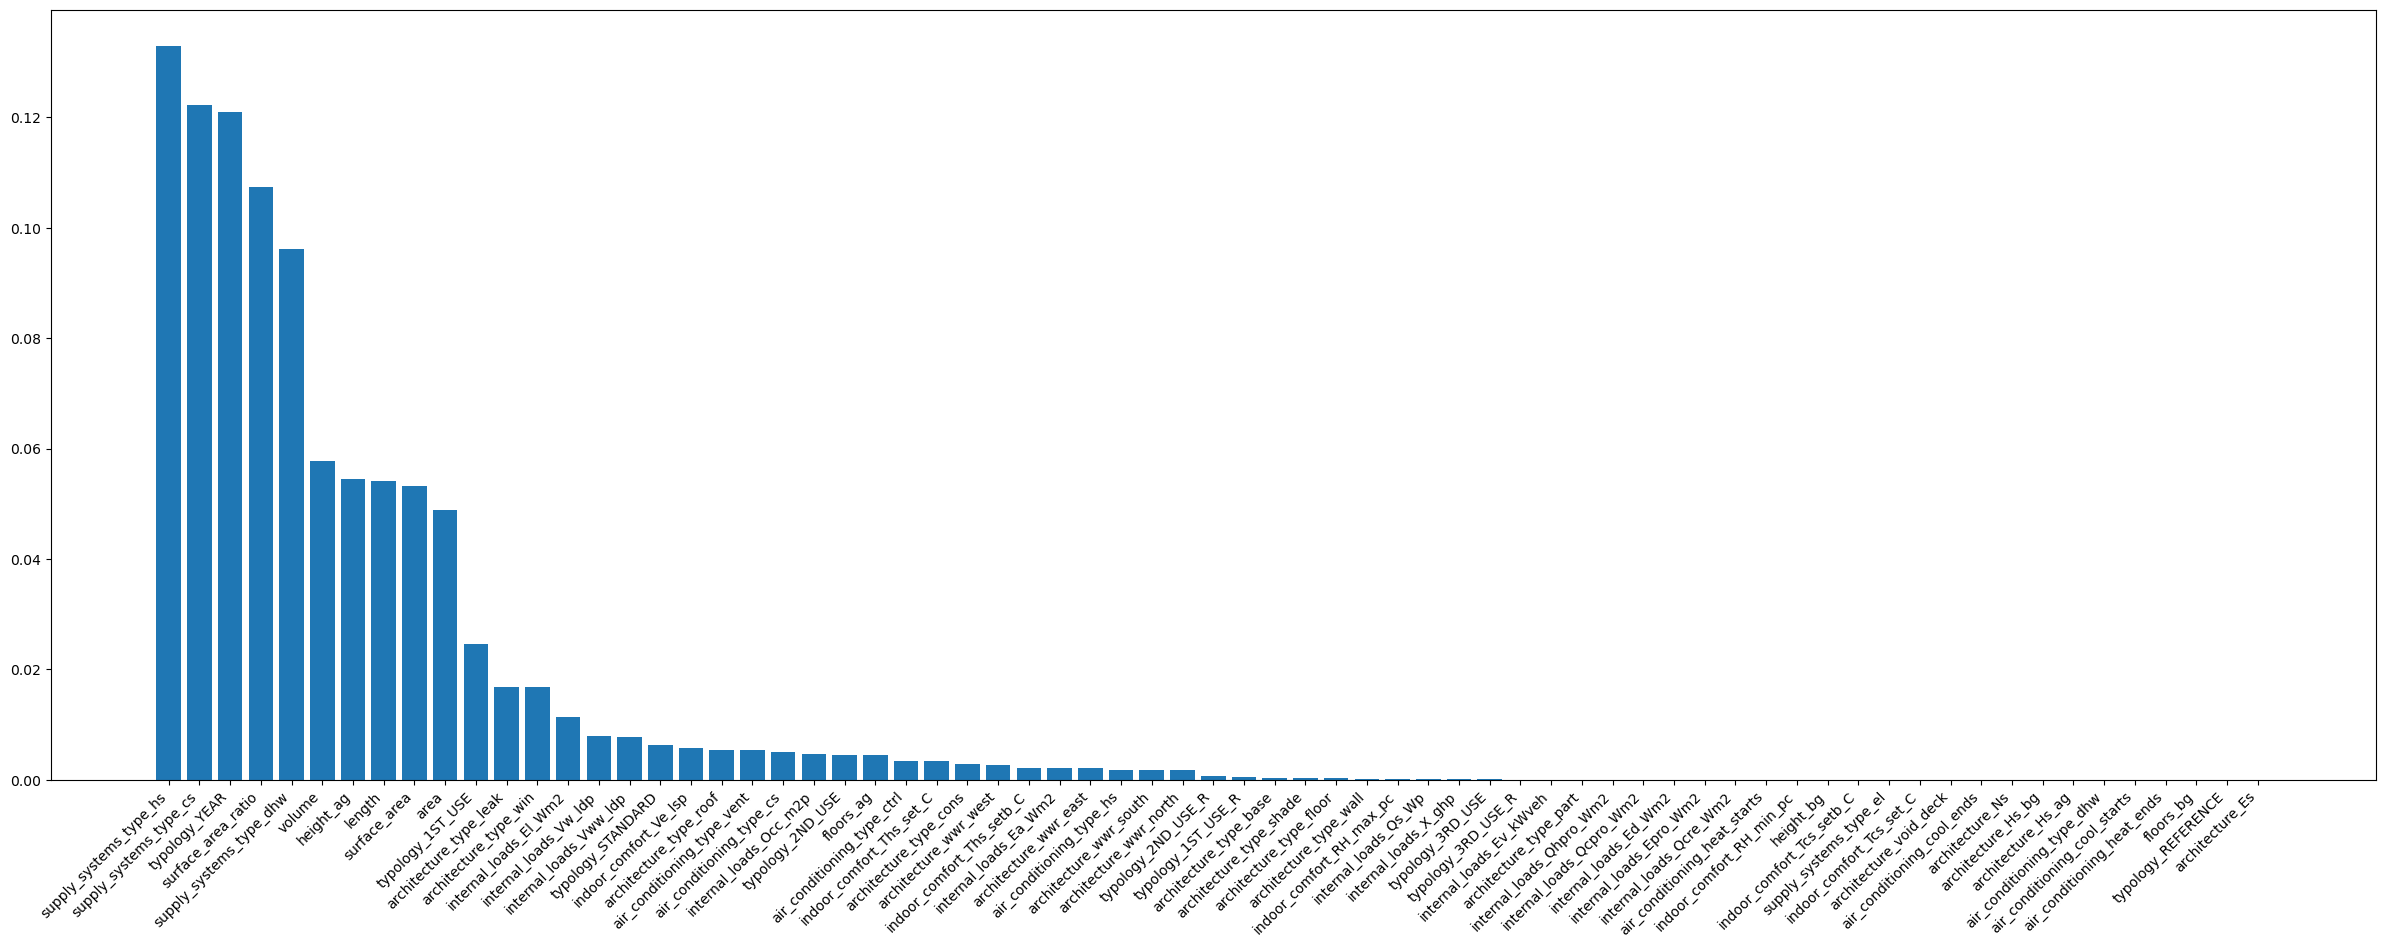

In [127]:
# plot the total importance of each category
plt.figure(figsize=(30, 10))
plt.bar(total_importance_regression_df['category'], 
        total_importance_regression_df['total_importance'])
plt.xticks(rotation=45, ha='right')
plt.show()

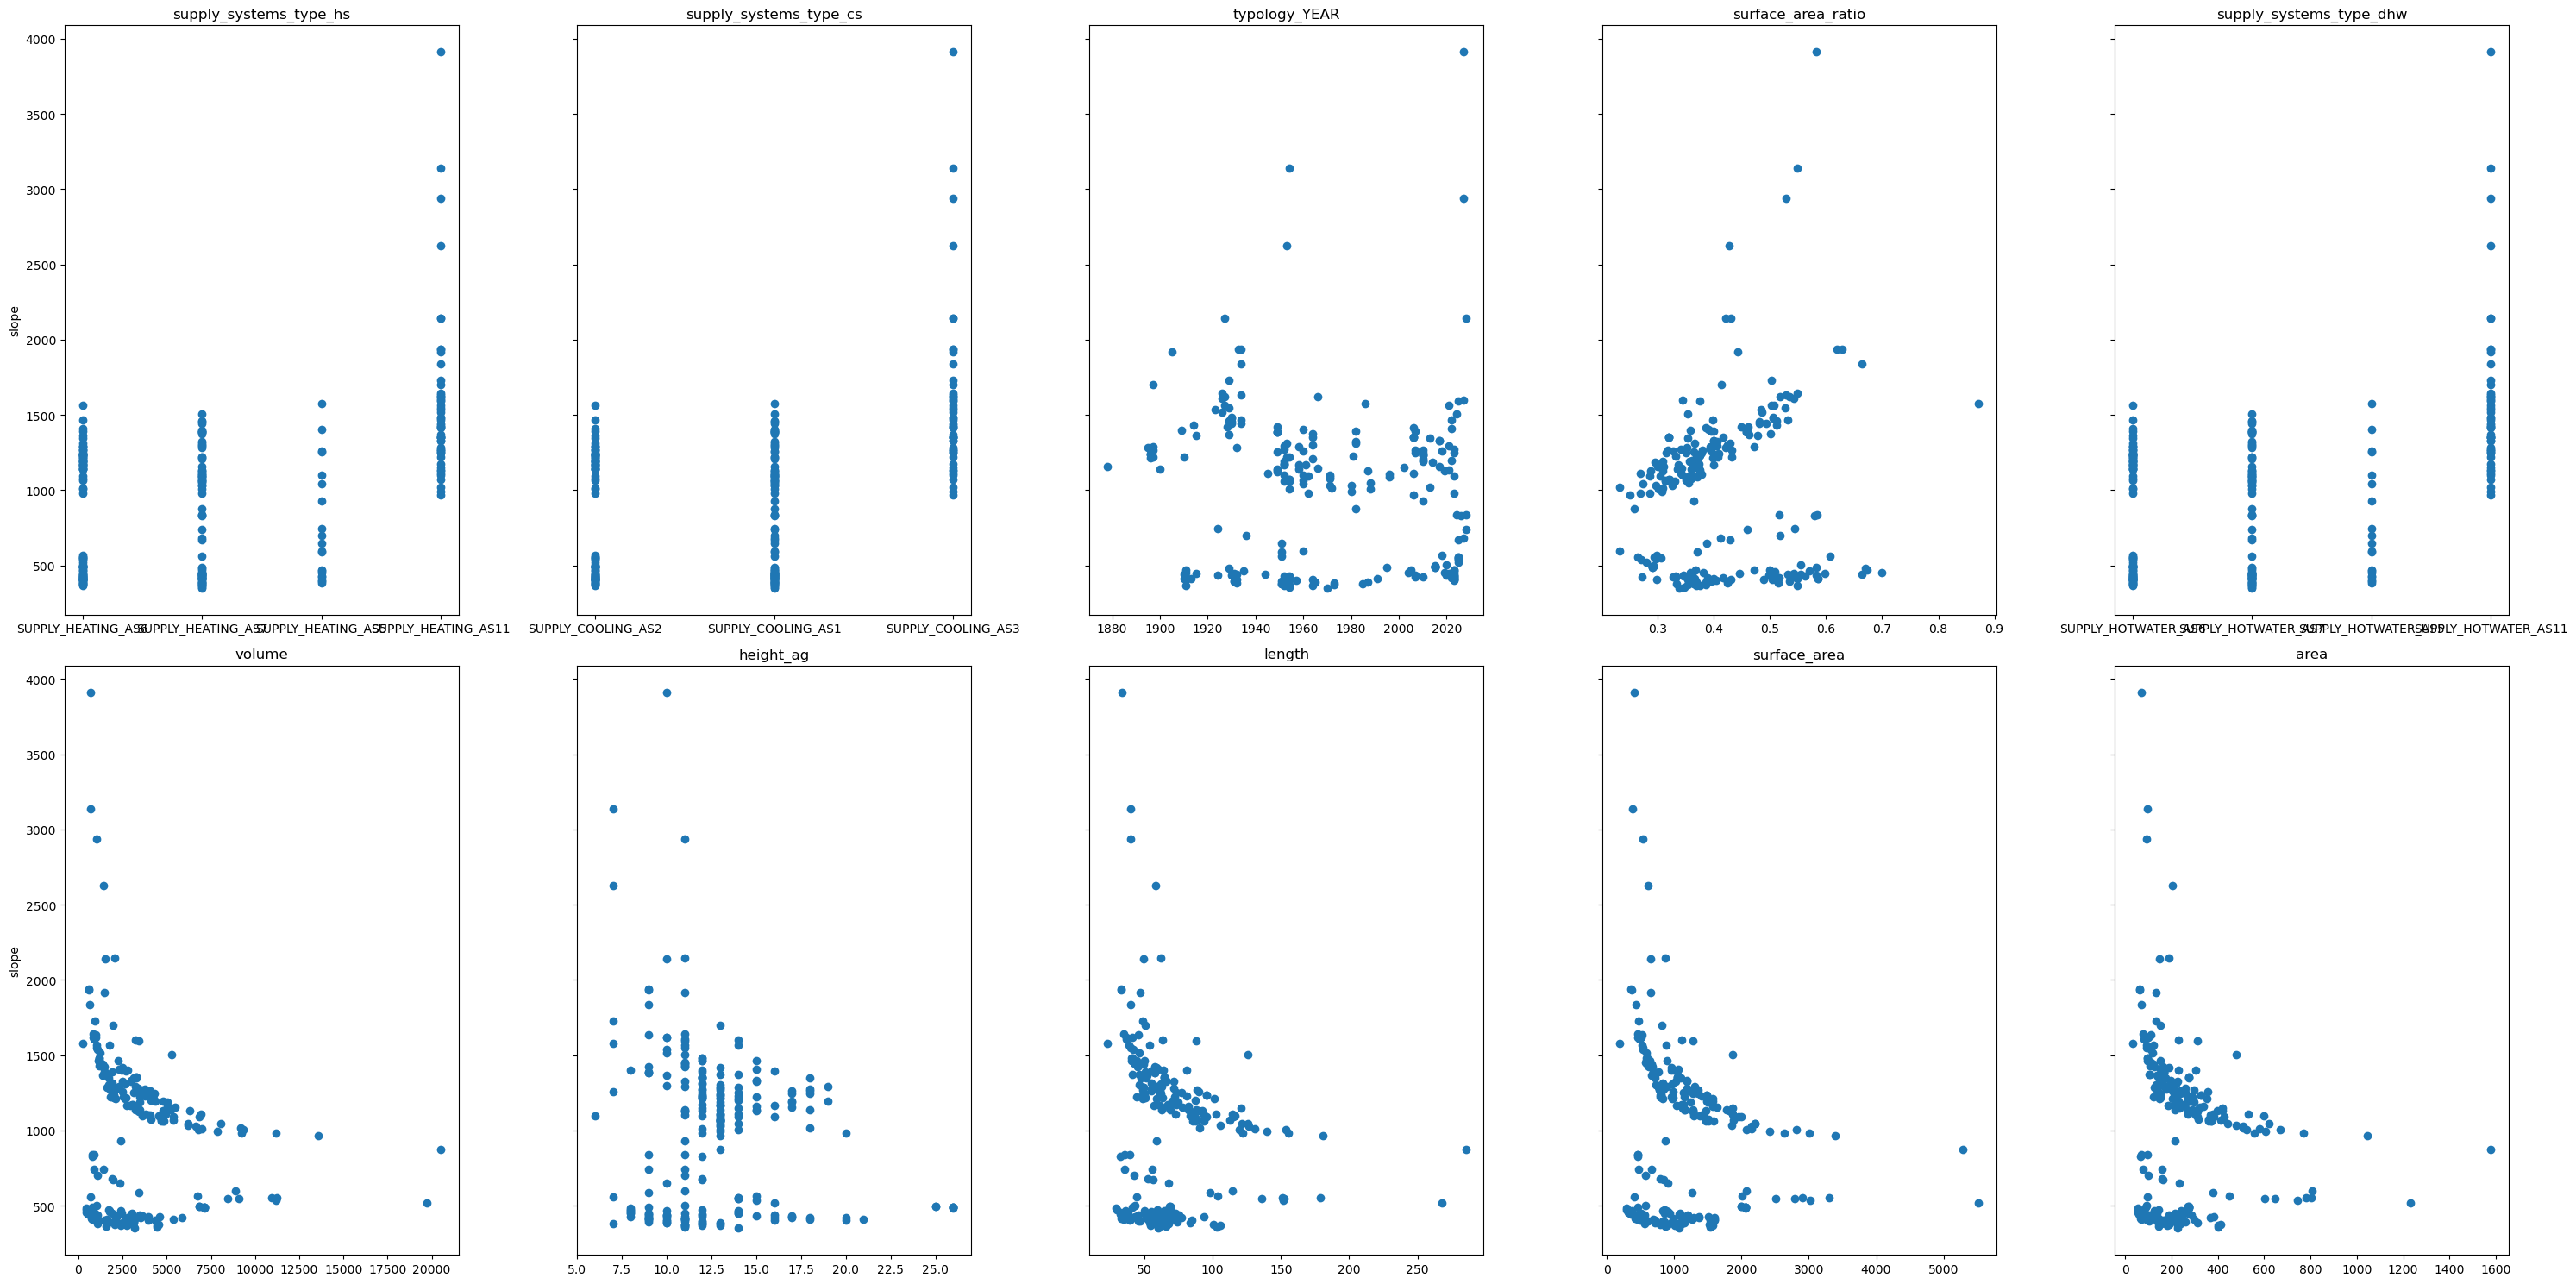

In [116]:
# create 6 scatter plots of the most important features, with x as the feature and y as the slope
# read the features from sorted feature importance dataframe
ls_important_features = list(total_importance_regression_df['category'][:10])
# set the plot with 6 subplots and use common y axis
fig, axs = plt.subplots(2, 5, figsize=(30, 15), sharey=True)
# plot the scatter plots
for i in range(2):
    for j in range(5):
        axs[i, j].scatter(X[ls_important_features[i * 5 + j]], y2)
        if j == 0:
            axs[i, j].set_ylabel('slope')
        # set the tick to 45 degree and align to the right
        axs[i, j].tick_params(axis='x')
        
        # set the title of the subplot
        axs[i, j].set_title(ls_important_features[i * 5 + j])
        
# make the plot look nicer
plt.tight_layout()
plt.show()

In [126]:
# plot window construction vs slope
plt.figure(figsize=(10, 10))
# color the points with different window construction
color_dict = {'WINDOW_AS1': 'red', 'WINDOW_AS2': 'blue', 'WINDOW_AS4': 'green'}
plt.scatter(X['typology_STANDARD'], y2, c=color_dict[X['architecture_type_win'].values.tolist()])
plt.show()

TypeError: unhashable type: 'list'

<Figure size 1000x1000 with 0 Axes>